In [4]:
import numpy as np
import pandas as pd
import cPickle
import multiprocessing
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

### Reading tweets

In [5]:
review_train = pd.read_csv('../data/reviews_train.csv', encoding='utf-8')

In [6]:
review_train.head()

,text,label
0,"Хороший магазин для спокойной, неторопливой по...",1
1,В этом магазине заоблачные цены!!! Например тр...,-1
2,"Всем рекомендую этот ПАБ!!!!Бываем не часто, ...",1
3,"заказал соковыжималку и пылесос борк, позвонил...",1
4,Принимают заказ.Ждёшь три дня.Доставка не появ...,-1


In [7]:
texts, labels = review_train.text.values, review_train.label.values

### Reading vocabulary and embeddings

In [8]:
word2id, embeddings = cPickle.load(open('../data/w2v/vectors_l.pkl', 'rb'))
# word2id, embeddings = cPickle.load(open('../data/w2v/parkin_vectors.pkl', 'rb'))

In [9]:
vocabulary = word2id.keys()
eos_id = word2id[u'</s>']

### Lemmatizing and replacing words with ids

In [10]:
from nltk.tokenize import RegexpTokenizer
import pymorphy2

tokenizer = RegexpTokenizer(u'[а-яА-Яa-zA-Z]+')
morph = pymorphy2.MorphAnalyzer()

def text2seq(text):
    tokens_norm = [morph.parse(w)[0].normal_form for w in tokenizer.tokenize(text)]
    return [word2id[w] for w in tokens_norm if w in vocabulary] + [eos_id]

sample = texts[49]

print sample
print u' '.join(tokenizer.tokenize(sample))
print u' '.join([morph.parse(w)[0].normal_form for w in tokenizer.tokenize(sample)])
print text2seq(sample)

Заказывал принтер сетевой по безналичной оплате с доставкой в Самару. Доставили через 4 дня после оплаты. Всем доволен.
Заказывал принтер сетевой по безналичной оплате с доставкой в Самару Доставили через дня после оплаты Всем доволен
заказывать принтер сетевой по безналичный оплата с доставка в самар доставить через день после оплата весь довольный
[5814, 9452, 6700, 17, 30383, 2409, 8, 5692, 2, 7312, 4145, 183, 132, 117, 2409, 11, 2123, 0]


Dumping

Loading

In [11]:
X = cPickle.load(open('../data/X_review_train.pkl', 'rb'))

Distribution of sequences' lengths 

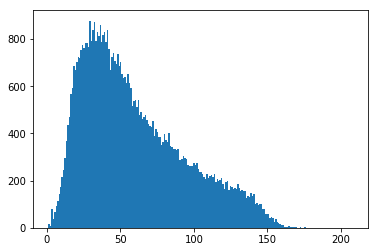

In [12]:
length_max = max(map(len, X))
plt.hist(map(len, X), bins=length_max);

Drop samples with the length > 150

In [13]:
length_max = 150
y = review_train.label.values
y = y[np.array(map(len, X)) <= length_max]
X = [x for x in X if len(x) <= length_max]

### Zero padding

In [14]:
X = [x + [eos_id]*(length_max - len(x)) for x in X]

### Examples

In [12]:
for x in X[:3]:
    print x

[65, 869, 43, 2135, 37924, 2799, 11, 1100, 802, 342, 1, 514, 373, 2, 2293, 127, 43, 10, 53, 151, 8, 4434, 7611, 78, 32611, 1038, 9653, 5, 29, 869, 2, 413, 582, 9, 1475, 2, 460, 1270, 1, 10, 7611, 827, 14, 2197, 8122, 11, 1475, 241, 9626, 59, 756, 1, 11, 67, 394, 1270, 704, 703, 5, 162, 35, 1, 48, 35, 96, 151, 133, 9, 57, 382, 9, 3, 637, 68, 194, 1270, 12, 4, 137, 221, 9, 291, 11898, 22, 2, 2332, 115, 43011, 7, 78, 5763, 1, 25, 1131, 1, 2729, 449, 489, 162, 1270, 48, 57, 194, 263, 3205, 5, 29, 869, 103, 48, 11, 172, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 7, 869, 15574, 217, 222, 901, 3705, 78611, 206, 197, 6, 2, 413, 645, 15, 206, 429, 197, 222, 5, 62, 21530, 2795, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Split into train and validation sets

In [13]:
X = np.array(X)

In [19]:
def cls2probs(cls):
    if cls == -1:
        return [1.,0.]
    else:
        return [0.,1.]
y = np.array([cls2probs(cls) for cls in y])

In [15]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.1

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=40)

In [16]:
print "Train class frequencies:\t", [col.nonzero()[0].shape[0] for col in y_tr.transpose()]
print "Validation class frequencies:\t", [col.nonzero()[0].shape[0] for col in y_val.transpose()]
print "Constant classifier's validation accuracy:\t", [col.nonzero()[0].shape[0] for col in y_val.transpose()][1] * 1. / y_val.shape[0]

Train class frequencies:	[10840, 42049]
Validation class frequencies:	[1209, 4668]
Constant classifier's validation accuracy:	0.794282797346


### Resampling

# Network learning

In [17]:
import tensorflow as tf
from tensorflow.contrib.rnn import GRUCell
from tensorflow.python.ops.rnn import bidirectional_dynamic_rnn as bi_rnn
from tensorflow.contrib.layers import fully_connected

from utils import *

In [26]:
from sklearn.metrics import f1_score
f_macro = lambda y1, y2: f1_score(y1, y2, average="macro")
f_micro = lambda y1, y2: f1_score(y1, y2, average="micro")

y_pred_major = np.zeros(y_val.shape)
y_pred_major[:,1] = 1.
print "Constant classifier's macro-averaged F-score on validation set:", f_macro(y_val, y_pred_major)
print "Constant classifier's micro-averaged F-score on validation set:", f_micro(y_val, y_pred_major)

NameError: name 'y_val' is not defined

### Bi-RNN

In [120]:
EMBED_DIM = 300
HIDDEN_SIZE = 600
NUM_CLASSES = 2

tf.reset_default_graph()

batch_ph   = tf.placeholder(tf.int32, [None, None])
target_ph  = tf.placeholder(tf.float32, [None, NUM_CLASSES])
seq_len_ph = tf.placeholder(tf.int32, [None])
keep_prob_ph = tf.placeholder(tf.float32)

embeddings_ph = tf.placeholder(tf.float32, [len(vocabulary), EMBED_DIM])
embeddings_var = tf.Variable(tf.constant(0., shape=[len(vocabulary), EMBED_DIM]), trainable=False)
init_embeddings = embeddings_var.assign(embeddings_ph)
batch_embedded = tf.nn.embedding_lookup(embeddings_var, batch_ph)
    
# Bi-RNN layers
outputs,_ = bi_rnn(GRUCell(HIDDEN_SIZE), GRUCell(HIDDEN_SIZE),
                   inputs=batch_embedded,sequence_length=seq_len_ph, dtype=tf.float32, scope="bi_rnn1")  
outputs = tf.concat(outputs, 2)
# outputs,_ = bi_rnn(GRUCell(HIDDEN_SIZE), GRUCell(HIDDEN_SIZE),
#                          inputs=outputs,sequence_length=seq_len_ph, dtype=tf.float32, scope="bi_rnn2")
# outputs = tf.concat(outputs, 2)

# Last output of Bi-RNN
output = outputs[:,0,:]

# Dropout
drop = tf.nn.dropout(output, keep_prob_ph)

# Fully connected layer
W = tf.Variable(tf.truncated_normal([HIDDEN_SIZE * 2, NUM_CLASSES], stddev=0.1), name="W")
b = tf.Variable(tf.constant(0., shape=[NUM_CLASSES]), name="b")
y_hat = tf.nn.xw_plus_b(drop, W, b, name="scores")

In [121]:
# Adam parameters
LEARNING_RATE = 9e-5
EPSILON = 1e-5
BETA1 = 0.9
BETA2 = 0.9
# L2 regularization coefficient
BETA = 0

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_hat, labels=target_ph),
                               name="cross_entropy")
l2_loss = tf.nn.l2_loss(W, name="l2_loss")
loss = cross_entropy + l2_loss * BETA
# optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE, beta1=BETA1, beta2=BETA2,
#                                    epsilon=EPSILON).minimize(loss)
optimizer = tf.train.MomentumOptimizer(learning_rate=1e-1, momentum=0.1).minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(target_ph, 1), tf.argmax(y_hat, 1)), tf.float32))

epoch: 14
	 Train loss: 0.227	 ce: 0.227	 acc: 0.895	 f_macro: 0.810
	 Valid loss: 0.236	 ce: 0.236	 acc: 0.890	 f_macro: 0.821


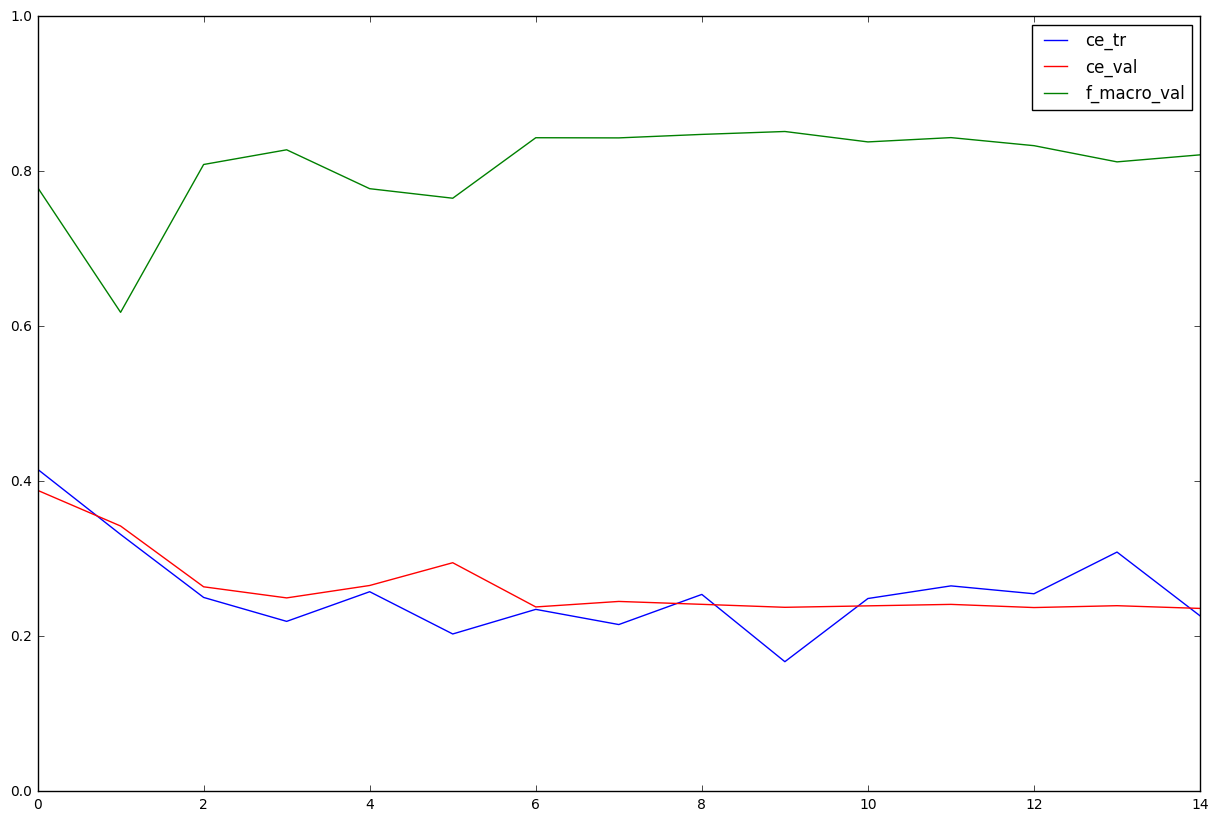

In [122]:
DROPOUT = 0.5  # Probability of keeping a neuron
BATCH_SIZE = 256
EPOCHS = 15

train_batch_generator = batch_generator(X_tr, y_tr, BATCH_SIZE)

loss_tr_l = []
loss_val_l = []
ce_tr_l = []  # Cross-entropy
ce_val_l = []
acc_tr_l = []  # Accuracy
acc_val_l = []
f_macro_tr_l = []
f_macro_val_l = []
f_fair_tr_l = []
f_fair_val_l = []
max_val_f = 0.

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(init_embeddings, feed_dict={embeddings_ph: embeddings})
    print "Start learning..."
    for epoch in range(EPOCHS):
        for i in range(int(X_tr.shape[0] / BATCH_SIZE)):
            x_batch, y_batch = train_batch_generator.next()
            seq_len_tr = np.array([list(x).index(eos_id) + 1 for x in x_batch])
            sess.run(optimizer, feed_dict={batch_ph: x_batch, target_ph: y_batch,
                                           seq_len_ph: seq_len_tr, keep_prob_ph: DROPOUT})

        y_pred_tr, ce_tr, loss_tr, acc_tr = sess.run([y_hat, cross_entropy, loss, accuracy],
                                              feed_dict={batch_ph: x_batch, target_ph: y_batch, 
                                                         seq_len_ph: seq_len_tr, keep_prob_ph: 1.0})

        y_pred_val, ce_val, loss_val, acc_val = [], 0, 0, 0
        num_val_batches = X_val.shape[0] / BATCH_SIZE
        for i in range(num_val_batches):
            x_batch_val, y_batch_val = X_val[i * BATCH_SIZE : (i + 1) * BATCH_SIZE],\
                                       y_val[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]
            seq_len_val = np.array([list(x).index(eos_id) + 1 for x in x_batch_val])
            y_pred_val_, ce_val_, loss_val_, acc_val_ = sess.run([y_hat, cross_entropy, loss, accuracy],
                                                         feed_dict={batch_ph: x_batch_val, target_ph: y_batch_val,
                                                                    seq_len_ph: seq_len_val, keep_prob_ph: 1.0})
            y_pred_val += list(y_pred_val_)
            ce_val += ce_val_
            loss_val += loss_val_
            acc_val += acc_val_

        y_pred_val = np.array(y_pred_val)
        ce_val /= num_val_batches
        loss_val /= num_val_batches
        acc_val /= num_val_batches

        y_pred_tr = np.array([cls2probs(cls) for cls in np.argmax(y_pred_tr, 1) - 1])
        y_pred_val = np.array([cls2probs(cls) for cls in np.argmax(y_pred_val, 1) - 1])
        f_macro_tr, f_micro_tr = f_macro(y_batch, y_pred_tr), f_micro(y_batch, y_pred_tr)
        f_macro_val, f_micro_val = f_macro(y_val[:num_val_batches * BATCH_SIZE], y_pred_val),\
                                   f_micro(y_val[:num_val_batches * BATCH_SIZE], y_pred_val)


        loss_tr_l.append(loss_tr)
        loss_val_l.append(loss_val)
        ce_tr_l.append(ce_tr)
        ce_val_l.append(ce_val)
        acc_tr_l.append(acc_tr)
        acc_val_l.append(acc_val)
        f_macro_tr_l.append(f_macro_tr)
        f_macro_val_l.append(f_macro_val)

        clear_output(wait=True)
        print "epoch: {}".format(epoch)
        print "\t Train loss: {:.3f}\t ce: {:.3f}\t acc: {:.3f}\t f_macro: {:.3f}".format(
            loss_tr, ce_tr, acc_tr, f_macro_tr)
        print "\t Valid loss: {:.3f}\t ce: {:.3f}\t acc: {:.3f}\t f_macro: {:.3f}".format(
            loss_val, ce_val, acc_val, f_macro_val)

        plt.figure(figsize=(15,10))
        plt.plot(ce_tr_l, color='blue', label='ce_tr')
        plt.plot(ce_val_l, color='red', label='ce_val')        
        plt.plot(f_macro_val_l, color='green', label='f_macro_val')
        plt.xlim(0, EPOCHS - 1)
        plt.ylim(0, 1)
        plt.legend()
        plt.show()
        
    results = [acc_val, f_macro_val]

    saver = tf.train.Saver() 
    saver.save(sess, 'model')

In [123]:
results

[0.88991477272727271, 0.82141921969101861]

---

### Bi-RNN with Attention mechanism

Attention mechanism formulas and notation
$$
\upsilon_{t}=\tanh{(W_{\omega}\left[\overrightarrow{h_{t}},\overleftarrow{h_{t}}\right]+b_{\omega})}\\
\alpha_{t}=\frac{\exp{(\upsilon_{t}^{T}u_{\omega})}}{\sum_{j=1}^{T}\exp{(\upsilon_{j}^{T}u_{\omega})}}\\
\upsilon=\sum_{t=1}^{T}\alpha_{t}h_{t}	
$$

In [19]:
EMBED_DIM = 300
SEQ_LENGTH = length_max
HIDDEN_SIZE = 600
ATTENTION_SIZE = 100
NUM_CLASSES = 2

tf.reset_default_graph()

batch_ph   = tf.placeholder(tf.int32, [None, SEQ_LENGTH])
target_ph  = tf.placeholder(tf.float32, [None, NUM_CLASSES])
seq_len_ph = tf.placeholder(tf.int32, [None])
keep_prob_ph = tf.placeholder(tf.float32)

embeddings_ph = tf.placeholder(tf.float32, [len(vocabulary), EMBED_DIM])
embeddings_var = tf.Variable(tf.constant(0., shape=[len(vocabulary), EMBED_DIM]), trainable=False)
init_embeddings = embeddings_var.assign(embeddings_ph)

batch_embedded = tf.nn.embedding_lookup(embeddings_var, batch_ph)

# Bi-RNN layers
outputs,_ = bi_rnn(GRUCell(HIDDEN_SIZE), GRUCell(HIDDEN_SIZE),
                   inputs=batch_embedded,sequence_length=seq_len_ph, dtype=tf.float32, scope="bi_rnn1")  
outputs = tf.concat(outputs, 2)
# outputs,_ = bi_rnn(GRUCell(HIDDEN_SIZE), GRUCell(HIDDEN_SIZE),
#                          inputs=outputs,sequence_length=seq_len_ph, dtype=tf.float32, scope="bi_rnn2")
# outputs = tf.concat(outputs, 2)

# Attention mechanism
W_omega = tf.Variable(tf.random_normal([2 * HIDDEN_SIZE, ATTENTION_SIZE], stddev=0.1))
b_omega = tf.Variable(tf.random_normal([ATTENTION_SIZE], stddev=0.1))
u_omega = tf.Variable(tf.random_normal([ATTENTION_SIZE], stddev=0.1))

v = tf.tanh(tf.matmul(tf.reshape(outputs, [-1, 2 * HIDDEN_SIZE]), W_omega) + tf.reshape(b_omega, [1, -1]))
vu = tf.matmul(v, tf.reshape(u_omega, [-1, 1]))
exps = tf.reshape(tf.exp(vu), [-1, SEQ_LENGTH])
alphas = exps / tf.reshape(tf.reduce_sum(exps, 1), [-1, 1])

# Output of Bi-RNN reduced with attention vector
output = tf.reduce_sum(outputs * tf.reshape(alphas, [-1, SEQ_LENGTH, 1]), 1)

# Dropout
drop = tf.nn.dropout(output, keep_prob_ph)

# Fully connected layer
W = tf.Variable(tf.truncated_normal([HIDDEN_SIZE * 2, NUM_CLASSES], stddev=0.1), name="W")
b = tf.Variable(tf.constant(0., shape=[NUM_CLASSES]), name="b")
y_hat = tf.nn.xw_plus_b(drop, W, b, name="scores")

In [20]:
# Adam parameters
LEARNING_RATE = 1e-1
EPSILON = 1e-5
BETA1 = 0.9
BETA2 = 0.9
# L2 regularization coefficient
BETA = 0

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=target_ph, logits=y_hat), name="cross_entropy")
l2_loss = tf.nn.l2_loss(W, name="l2_loss")
loss = cross_entropy + l2_loss * BETA
# optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE, beta1=BETA1, beta2=BETA2,
#                                    epsilon=EPSILON).minimize(loss)
# optimizer = tf.train.AdadeltaOptimizer(learning_rate=LEARNING_RATE, rho=0.7).minimize(loss)
# optimizer = tf.train.AdagradOptimizer(learning_rate=LEARNING_RATE, initial_accumulator_value=0.1).minimize(loss)
optimizer = tf.train.MomentumOptimizer(learning_rate=LEARNING_RATE, momentum=0.1).minimize(loss)
# optimizer = tf.train.RMSPropOptimizer(learning_rate=LEARNING_RATE, decay=0.9, momentum=0.1).minimize(loss)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(target_ph, 1), tf.argmax(y_hat, 1)), tf.float32))

epoch: 14
	 Train loss: 0.223	 ce: 0.223	 acc: 0.918	 f_macro: 0.870
	 Valid loss: 0.227	 ce: 0.227	 acc: 0.892	 f_macro: 0.832


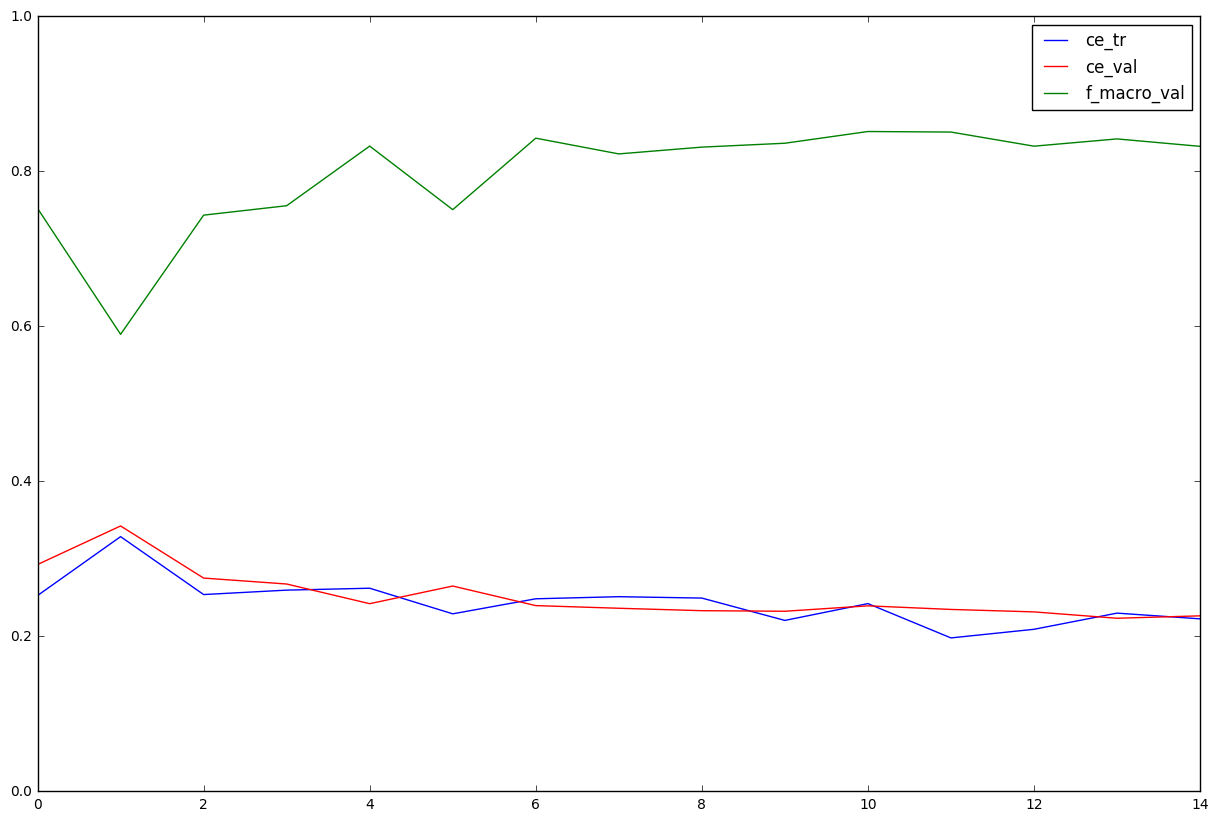

In [21]:
DROPOUT = 0.5  # Probability of keeping a neuron
BATCH_SIZE = 256
EPOCHS = 15

train_batch_generator = batch_generator(X_tr, y_tr, BATCH_SIZE)

loss_tr_l = []
loss_val_l = []
ce_tr_l = []  # Cross-entropy
ce_val_l = []
acc_tr_l = []  # Accuracy
acc_val_l = []
f_macro_tr_l = []
f_macro_val_l = []
f_fair_tr_l = []
f_fair_val_l = []
max_val_f = 0.

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(init_embeddings, feed_dict={embeddings_ph: embeddings})
    print "Start learning..."
    for epoch in range(EPOCHS):
        for i in range(int(X_tr.shape[0] / BATCH_SIZE)):
            x_batch, y_batch = train_batch_generator.next()
            seq_len_tr = np.array([list(x).index(eos_id) + 1 for x in x_batch])
            sess.run(optimizer, feed_dict={batch_ph: x_batch, target_ph: y_batch,
                                           seq_len_ph: seq_len_tr, keep_prob_ph: DROPOUT})

        y_pred_tr, ce_tr, loss_tr, acc_tr = sess.run([y_hat, cross_entropy, loss, accuracy],
                                              feed_dict={batch_ph: x_batch, target_ph: y_batch, 
                                                         seq_len_ph: seq_len_tr, keep_prob_ph: 1.0})

        y_pred_val, ce_val, loss_val, acc_val = [], 0, 0, 0
        num_val_batches = X_val.shape[0] / BATCH_SIZE
        for i in range(num_val_batches):
            x_batch_val, y_batch_val = X_val[i * BATCH_SIZE : (i + 1) * BATCH_SIZE],\
                                       y_val[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]
            seq_len_val = np.array([list(x).index(eos_id) + 1 for x in x_batch_val])
            y_pred_val_, ce_val_, loss_val_, acc_val_ = sess.run([y_hat, cross_entropy, loss, accuracy],
                                                         feed_dict={batch_ph: x_batch_val, target_ph: y_batch_val,
                                                                    seq_len_ph: seq_len_val, keep_prob_ph: 1.0})
            y_pred_val += list(y_pred_val_)
            ce_val += ce_val_
            loss_val += loss_val_
            acc_val += acc_val_

        y_pred_val = np.array(y_pred_val)
        ce_val /= num_val_batches
        loss_val /= num_val_batches
        acc_val /= num_val_batches

        y_pred_tr = np.array([cls2probs(cls) for cls in np.argmax(y_pred_tr, 1) - 1])
        y_pred_val = np.array([cls2probs(cls) for cls in np.argmax(y_pred_val, 1) - 1])
        f_macro_tr, f_micro_tr = f_macro(y_batch, y_pred_tr), f_micro(y_batch, y_pred_tr)
        f_macro_val, f_micro_val = f_macro(y_val[:num_val_batches * BATCH_SIZE], y_pred_val),\
                                   f_micro(y_val[:num_val_batches * BATCH_SIZE], y_pred_val)


        loss_tr_l.append(loss_tr)
        loss_val_l.append(loss_val)
        ce_tr_l.append(ce_tr)
        ce_val_l.append(ce_val)
        acc_tr_l.append(acc_tr)
        acc_val_l.append(acc_val)
        f_macro_tr_l.append(f_macro_tr)
        f_macro_val_l.append(f_macro_val)

        clear_output(wait=True)
        print "epoch: {}".format(epoch)
        print "\t Train loss: {:.3f}\t ce: {:.3f}\t acc: {:.3f}\t f_macro: {:.3f}".format(
            loss_tr, ce_tr, acc_tr, f_macro_tr)
        print "\t Valid loss: {:.3f}\t ce: {:.3f}\t acc: {:.3f}\t f_macro: {:.3f}".format(
            loss_val, ce_val, acc_val, f_macro_val)

        plt.figure(figsize=(15,10))
        plt.plot(ce_tr_l, color='blue', label='ce_tr')
        plt.plot(ce_val_l, color='red', label='ce_val')        
        plt.plot(f_macro_val_l, color='green', label='f_macro_val')
        plt.xlim(0, EPOCHS - 1)
        plt.ylim(0, 1)
        plt.legend()
        plt.show()
        
    results = [acc_val, f_macro_val]

    saver = tf.train.Saver() 
    saver.save(sess, 'model_att')

In [22]:
results

[0.89186789772727271, 0.83238913535332038]

---

---

---

# Testing

In [20]:
review_test = pd.read_csv('../data/reviews_test.csv', sep=',', encoding='utf-8')
texts_test, labels_test = review_test.text.values, review_test.label.values

In [21]:
X_test = cPickle.load(open('../data/X_reviews_test.pkl', 'rb'))

In [22]:
X_test = [x[:length_max - 1] for x in X_test]
X_test = [x + [eos_id]*(length_max - len(x)) for x in X_test]
X_test = np.array(X_test)
y_test = np.array([cls2probs(cls) for cls in labels_test])

In [23]:
X_test.shape, y_test.shape

((14784, 150), (14784, 2))

In [27]:
print "Constant classifier's test accuracy:\t", [col.nonzero()[0].shape[0] for col in y_test.transpose()][1] * 1. / y_test.shape[0]
y_pred_major = np.zeros(y_test.shape)
y_pred_major[:,1] = 1.
print "Constant classifier's macro-averaged F-score on validation set:", f_macro(y_test, y_pred_major)

Constant classifier's test accuracy:	0.793695887446
Constant classifier's macro-averaged F-score on validation set: 0.4424918923


/home/ilivans/.virtualenvs/cmn/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [27]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('model_att.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))

    y_pred_test, ce_test, loss_test, acc_test = [], 0, 0, 0
    num_test_batches = X_test.shape[0] / BATCH_SIZE
    for i in range(num_test_batches):
        x_batch_test, y_batch_test = X_test[i * BATCH_SIZE : (i + 1) * BATCH_SIZE],\
                                   y_test[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]
        seq_len_test = np.array([list(x).index(eos_id) + 1 for x in x_batch_test])
        y_pred_test_, ce_test_, loss_test_, acc_test_ = sess.run([y_hat, cross_entropy, loss, accuracy],
                                                     feed_dict={batch_ph: x_batch_test, target_ph: y_batch_test,
                                                                seq_len_ph: seq_len_test, keep_prob_ph: 1.0})
        y_pred_test += list(y_pred_test_)
        ce_test += ce_test_
        loss_test += loss_test_
        acc_test += acc_test_

    y_pred_test = np.array(y_pred_test)
    ce_test /= num_test_batches
    loss_test /= num_test_batches
    acc_test /= num_test_batches

In [28]:
y_pred_test = np.array([cls2probs(cls) for cls in np.argmax(y_pred_test, 1) - 1])
f_macro_test = f_macro(y_test[:num_test_batches * BATCH_SIZE], y_pred_test)
print acc_test, f_macro_test

0.894188596491 0.837713442744


---

## Attention weights

In [59]:
id2word = {}
for word, word_id in word2id.iteritems():
    id2word[word_id] = word

In [84]:
print " ".join(map(id2word.get, X_test[20]))

заведение вполне приличный кухня хороший но маловато выбор зато с напиток никакой проблема выбор нет много сорт пиво и другой более крепкий напиток из минус можно сказать только черезмерный громкость живой музыка по выходной сосед не слышный нравиться отзыв </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>


In [86]:
sentence = u"Заведение вполне приличное, кухня хорошая, но маловато выбора, зато с напитками никакой проблемы выбора нет!! много сортов пива и других более крепких напитков. из минусов можно сказать только черезмерная громкость живой музыки по выходным. соседа не слышно.... "
print sentence

Заведение вполне приличное, кухня хорошая, но маловато выбора, зато с напитками никакой проблемы выбора нет!! много сортов пива и других более крепких напитков. из минусов можно сказать только черезмерная громкость живой музыки по выходным. соседа не слышно.... 


In [88]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('model_att.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    x_batch_test, y_batch_test = X_test[20:21], y_test[20:21]
    seq_len_test = np.array([list(x).index(eos_id) + 1 for x in x_batch_test])
    y_pred_test, alphas_test = sess.run([y_hat, alphas],
                                                 feed_dict={batch_ph: x_batch_test, target_ph: y_batch_test,
                                                            seq_len_ph: seq_len_test, keep_prob_ph: 1.0})

In [89]:
y_pred_test

array([[-1.1794126,  0.9992699]], dtype=float32)

In [119]:
for word, coef in zip(sentence.split()[:37], alphas_test[0,:37] * 1000 / 1.7):
    print "\colorbox{yellow!%d}{%s}" % (int(coef), word)

\colorbox{yellow!14}{Заведение}
\colorbox{yellow!41}{вполне}
\colorbox{yellow!62}{приличное,}
\colorbox{yellow!78}{кухня}
\colorbox{yellow!99}{хорошая,}
\colorbox{yellow!27}{но}
\colorbox{yellow!25}{маловато}
\colorbox{yellow!11}{выбора,}
\colorbox{yellow!8}{зато}
\colorbox{yellow!2}{с}
\colorbox{yellow!2}{напитками}
\colorbox{yellow!2}{никакой}
\colorbox{yellow!2}{проблемы}
\colorbox{yellow!3}{выбора}
\colorbox{yellow!2}{нет!!}
\colorbox{yellow!2}{много}
\colorbox{yellow!2}{сортов}
\colorbox{yellow!2}{пива}
\colorbox{yellow!3}{и}
\colorbox{yellow!2}{других}
\colorbox{yellow!1}{более}
\colorbox{yellow!2}{крепких}
\colorbox{yellow!1}{напитков.}
\colorbox{yellow!1}{из}
\colorbox{yellow!3}{минусов}
\colorbox{yellow!3}{можно}
\colorbox{yellow!4}{сказать}
\colorbox{yellow!4}{только}
\colorbox{yellow!10}{черезмерная}
\colorbox{yellow!8}{громкость}
\colorbox{yellow!12}{живой}
\colorbox{yellow!8}{музыки}
\colorbox{yellow!4}{по}
\colorbox{yellow!5}{выходным.}
\colorbox{yellow!6}{соседа}
\colorb